In [1]:
from IPython.display import HTML, Image
import matplotlib.pyplot as plt
import torch
import sys  
import os
from functools import partial

sys.path.insert(0, '../../..')

from dynnn.simulation.mve_ensemble import MveEnsembleMechanics
from dynnn.simulation.mve_ensemble.viz import visualize_trajectory, plot_energy
from dynnn.simulation.mve_ensemble.mve_ensemble import energy_conservation_loss, calc_kinetic_energy, get_initial_conditions
from dynnn.train import train

In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--device', default="cpu", type=str, help="device to run on")
    parser.add_argument('--batch_size', default=1000, type=int, help='batch size')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-5, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=3000, type=int, help='number of gradient steps')
    parser.add_argument('--n_bodies', default=20, type=int, help='number of particles')
    parser.add_argument('--n_dims', default=3, type=int, help='number of dimensions')
    parser.add_argument('--field_type', default='port', type=str, help='type of vector field to learn (if Hamiltonian)') # solenoidal, conservative, port
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

args = get_args()

torch.set_default_device(args.device)

In [3]:
mechanics = MveEnsembleMechanics()
# torch.Size([150, 10, 3]) torch.Size([150, 10, 3]) torch.Size([150]) torch.Size([10])

def plot_energy_from_coords(r, v, time, masses):
    pe = mechanics.no_bc_potential_fn(r).detach().cpu()
    ke = calc_kinetic_energy(v, masses).detach().cpu()
    te = pe + ke

    plot_energy(pe, ke, te, time.cpu())

Trajectory d39ecea0c9604551a7c476f5f682cda0: 500 steps (last t: tensor([5.3687], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 1000 steps (last t: tensor([8.0938], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 1500 steps (last t: tensor([10.1577], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 2000 steps (last t: tensor([15.1667], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 2500 steps (last t: tensor([16.7075], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 3000 steps (last t: tensor([18.1828], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 3500 steps (last t: tensor([19.9007], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 4000 steps (last t: tensor([27.6166], grad_fn=<AddBackward0>))
Trajectory d39ecea0c9604551a7c476f5f682cda0: 4500 steps (last t: tensor([28.5899], grad_fn=<AddBackward0>))


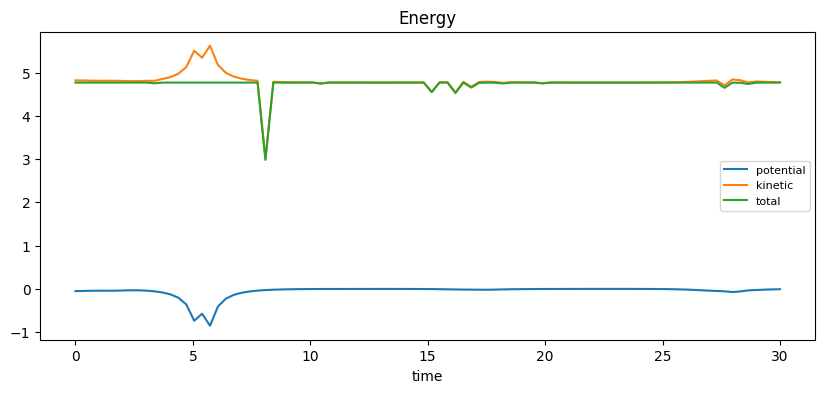

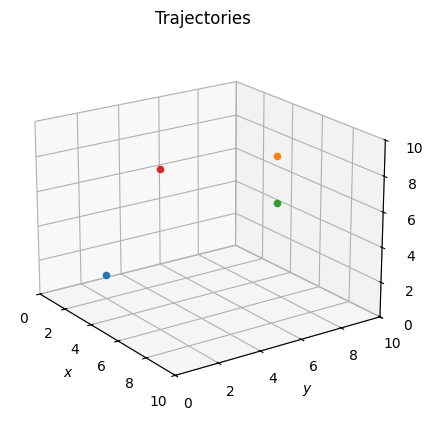

In [4]:
y0, masses = get_initial_conditions(args.n_bodies, args.n_dims)

r, v, dr, dv, time = mechanics.get_trajectory({ "y0": y0, "masses": masses }).dict().values()
plot_energy_from_coords(r, v, time, masses)
ani = visualize_trajectory(r.detach().cpu(), len(time), mechanics.domain)
HTML(ani.to_jshtml())

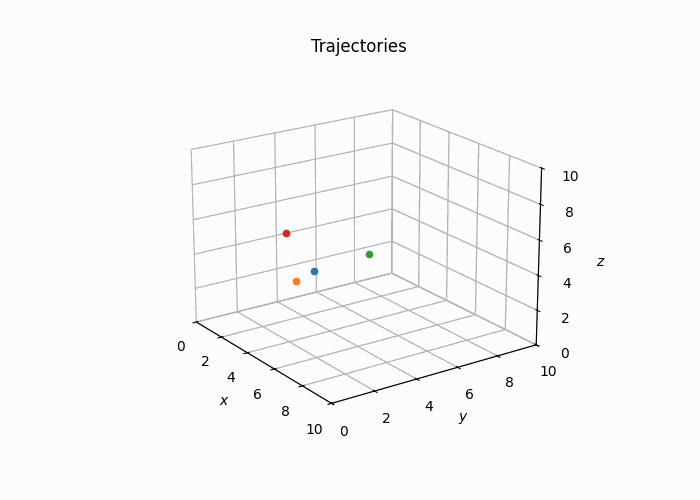

In [5]:
ani.save(sys.path[0] + '/../images/mve_ensemble.gif', writer='pillow')
Image(filename=sys.path[0] + '/../images/mve_ensemble.gif')

In [6]:
data = mechanics.get_dataset({}, { "y0": y0, "masses": masses })

Creating hamiltonian data...
Trajectory 89966ca6711e4098800421cab8e4d800: 500 steps (last t: tensor([5.3687], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 1000 steps (last t: tensor([8.0938], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 1500 steps (last t: tensor([10.1577], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 2000 steps (last t: tensor([15.1667], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 2500 steps (last t: tensor([16.7075], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 3000 steps (last t: tensor([18.1828], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 3500 steps (last t: tensor([19.9007], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 4000 steps (last t: tensor([27.6166], grad_fn=<AddBackward0>))
Trajectory 89966ca6711e4098800421cab8e4d800: 4500 steps (last t: tensor([28.5899], grad_fn=<AddBackward0>))
Tr

In [ ]:
# check data
data_r, data_v = [v.squeeze(-2) for v in torch.split(data["x"][0], 1, dim=-2)]
plot_energy_from_coords(data_r, data_v, data["time"], masses)
ani = visualize_trajectory(data_r, len(data["time"]), mechanics.domain)
HTML(ani.to_jshtml())

In [ ]:
# train model
args.additional_loss = partial(energy_conservation_loss, masses=masses)
# args.additional_loss = None

model, stats = train(args, data)

In [ ]:
fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title("Loss")
plt.xlabel("time")
plt.plot(stats["train_loss"], label="train_loss")
plt.plot(stats["test_loss"], label="test_loss")
plt.legend(fontsize=8)

fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title("Zoomed-in final loss")
plt.xlabel("time")
plt.plot(stats["train_loss"][-500:], label="train_loss")
plt.plot(stats["test_loss"][-500:], label="test_loss")
plt.legend(fontsize=8)

In [ ]:
# plot model output

test_y0, test_masses = get_initial_conditions(args.n_bodies, args.n_dims)
initial_state = test_y0.clone().detach().requires_grad_()
r, v, dr, dv, time = mechanics.get_trajectory({"y0": initial_state, "masses": test_masses, "model": model}).dict().values()
plot_energy_from_coords(r, v, time, test_masses)

ani_model = visualize_trajectory(r, len(time), mechanics.domain)
HTML(ani_model.to_jshtml())